# Time Series Analysis of USD/INR Exchange rate

### Task
To utilize various time series concepts to analyse and predict the daily exchange rate of Indian Rupee against the United States Dollar. 

Historical Data Source - https://www.investing.com/currencies/usd-inr-historical-data

#### Getting Systems ready and loading the data

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from pandas import Series
%matplotlib inline 
import warnings

# ignoring warnings 
warnings.filterwarnings("ignore")

# reading data from csv
# Also parsing dates as Datetime so that we can extract features like year and months later on.
# making date colum out index since we are doing Time Series analysis 
data = pd.read_csv("USD_INR Historical Data.csv", index_col='Date', parse_dates=True)

# checking current python version
print("Using python version " + sys.version)

# data.head()

Using python version 3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) 
[Clang 6.0 (clang-600.0.57)]


#### Filling missing data and Extracting features
* Adding the missing dates and filling it with last known value. 
* Extracting year, month and day from Date so that we can examin them later 

In [2]:
# adding missing dates and filling with last known value
index = pd.date_range('01-02-2002','12-31-2020')
data = data.reindex(index, method='backfill')
data['Price']

# Dropping colums that we don't need
data = data.drop(['Open', 'High', 'Low', 'Change %'], axis= 1)

# making a copy 
data_copy = data.copy()

## Modeling and Evaluation




### Splitting Data into traing, testing and validation part

Before training or model we need to split our data into training data, validation data, and testing data 

* Training Data ( 10 years )
 * This is the data set we will use to train/ fit our models on once we have figured out the the best parameters for out model. 
* Validation Data ( 3 months )
  * This is the data set we will use to check our tentatively performace and tune our parameters
* Training - validation ( 9 years, 9 months )
 * We will train this data set first and try to figure out parameters too maximize our performance on the validation dataset. 
* Testing Data 
  * We will use two types of testing to measure performance of our models
   * predicting a month in advance ( 1 month )
   * predicting a year in advance ( 1 year )


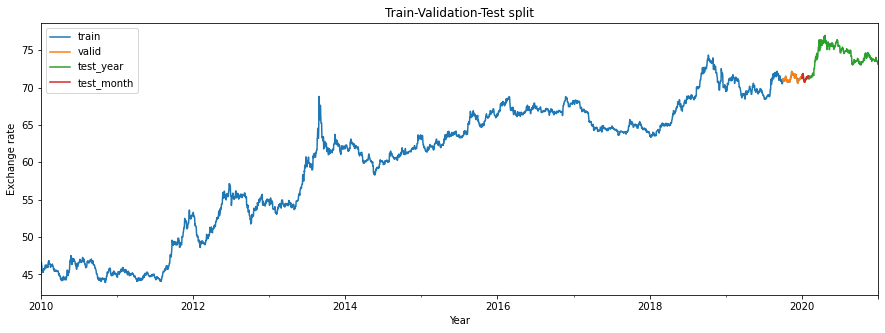

In [3]:
train = data['01-01-2010':'01-01-2020']
valid = data['10-01-2019':'01-01-2020']
train_valid = data['01-01-2010':'10-01-2019']
test_month = data['01-01-2020':'02-01-2020']
test_year = data['01-01-2020':'01-01-2021']

train.Price.plot(figsize=(15,5), title = 'Train-Validation-Test split', label = 'train')
valid.Price.plot(label = 'valid')
test_year.Price.plot(label='test_year')
test_month.Price.plot(label= 'test_month')
plt.xlabel('Year')
plt.ylabel('Exchange rate')
plt.legend(loc='best')
plt.show()

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Time Series Cross Validation
Up till now we have used a single validation period to select our best model. the weakness of that approach is that it gives you a sample size of 1 (that's better than nothing, but generally poor satatics!). Time series cross validation is called a **Rolling Forecast origin**. There may also be benefit of taking a **sliding window** approach to cross validation. This second approach maintains a fixed siezed training set. i.e. it drops older valuses from the time series during validaion.



### Rolling Forecast Origin
> Usually If we are predicting something in practice we only need to predict data for the near future, and once data for that period is available than we can include that in our prediction and predict the next near future period and so on. 

### Sliding Window
> Similar to rolling forecast origin but size of training split is fixed (30 in our case). 

### Spliting data into multiple train and test sets

#### For validation data

In [6]:
# spliting into multiple train and validation sets for rollign forecast  

min_train_size = 30
horizon = 7

rolling_split_train = []
rolling_split_val = []

for i in range(3528, len(train)- min_train_size - horizon + 1 ,horizon):
    rolling_split_train.append(train[:min_train_size + i])
    rolling_split_val.append(train[min_train_size + i : min_train_size + i + horizon])
    
#splitting data into multiple train and validation set for sliding window

horizon = 7
window_size = 30

sliding_split_train = []
sliding_split_val = []

for i in range(3528, len(train)- window_size - horizon + 1 ,horizon):
    sliding_split_train.append(train[i:window_size + i])
    sliding_split_val.append(train[window_size + i : window_size + i + horizon])

print(len(rolling_split_train))

13


#### For test data

In [7]:
train = data['01-01-2010':'01-01-2020']
valid = data['10-01-2019':'01-01-2020']
train_valid = data['01-01-2010':'10-01-2019']
test_month = data['01-01-2020':'02-01-2020']
test_year = data['01-01-2020':'01-01-2021']

all_data = data['01-01-2010':'01-01-2021']
# train_monthly = ['01-01-2010':'02-01-2020']


min_train_size = 30
horizon = 7

rolling_split_train_all = []
rolling_split_val_all = []

for i in range(3622, len(all_data)- min_train_size - horizon + 1 ,horizon):
    rolling_split_train_all.append(all_data[:min_train_size + i])
    rolling_split_val_all.append(all_data[min_train_size + i : min_train_size + i + horizon])
    
#splitting data into multiple train and validation set for sliding window

horizon = 7
window_size = 30

sliding_split_train_all = []
sliding_split_val_all = []

for i in range(3622, len(all_data)- window_size - horizon + 1 ,horizon):
    sliding_split_train_all.append(all_data[i:window_size + i])
    sliding_split_val_all.append(all_data[window_size + i : window_size + i + horizon])

print(len(rolling_split_train_all))


52


Creating a function to run different models on multiple time-test split

In [8]:
import os
def clear():
    os.system( 'cls' )

def forecast(split_train, split_val, test_real, start_date, end_date,label_one,label_two, naive, ses, holt, holt_winter, sarima):
    
    result_exp_smoothing = pd.DataFrame()
    result_naive = pd.DataFrame()
    result_holt = pd.DataFrame()
    result_holt_winter = pd.DataFrame()
    result_sarima = pd.DataFrame()

    # training all the models for all the train-val splits 
    for i in range(len(split_val)):
    
        tra = split_train[i]
        val = split_val[i]
    
        # naive 
        if naive :
            dd = np.asarray(tra.Price)
            y_hat = val.copy()
            # last observed value 
            y_hat['Price'] = dd[len(dd)-1]
            result_naive = pd.concat([result_naive, y_hat])
        
    
        # simple exponential smoothing
        if ses :
            ses_model = SimpleExpSmoothing(tra['Price']).fit(smoothing_level = 0.6, optimized= True)
            df = ses_model.forecast(len(val)).to_frame()
            df = df.rename(columns = {0:'Price'})
            result_exp_smoothing = pd.concat([result_exp_smoothing,df])
    
        # Holt's exponential smoothing
        if holt :
            holt_model = Holt(tra['Price'], exponential=False).fit(smoothing_level = 0.6, optimized= True)
            df1 = holt_model.forecast(len(val)).to_frame()
            df1 = df.rename(columns = {0:'Price'})
            result_holt = pd.concat([result_holt,df1])
    
        # Holt winters exponential smoothing
        if holt_winter:
            holt_winter_model = ExponentialSmoothing(tra['Price'], trend = 'add', seasonal = 'mul', seasonal_periods = 12).fit(smoothing_level = 0.6, optimized= True)
            df2 = holt_winter_model.forecast(len(val)).to_frame()
            df2 = df.rename(columns = {0:'Price'})
            result_holt_winter = pd.concat([result_holt_winter,df2])
        
        # seasonal arima
        if sarima:
            s = (str(val.index[0].date()))
            e = (str(val.index[len(val)-1].date()))

            sarima_model = SARIMAX(tra['Price'], order=(2,1,2), seasonal_order=(0,1,1,12)).fit()
            df = sarima_model.predict(start= s, end= e).to_frame()
            df = df.rename(columns = {0:'Price'})
            result_sarima = pd.concat([result_sarima,df])
            
            # printing training progress. 
            # print(str((i+1)*100/(len(split_val))) + "% done.")
    

    print("")
    
    
    if naive :
        test_real[start_date:end_date].Price.plot(label = "Orignal data",figsize=(15,5))
        result_naive[start_date : end_date].Price.plot(label = "Naive method")

        
        residuals = test_real[start_date:end_date].Price - result_naive[start_date:end_date].Price
        rmse = round(np.sqrt(np.mean(residuals**2)),4)
        mape = round(np.mean(abs(residuals/test_real[start_date:end_date].Price)),4)
        
        print('------------------------------------------------\n')
        print("Naive method:")
        print("Root Mean Squared Error: "+ str(rmse))
        print("Mean Absolute Percent Error: " + str(mape*100) + "%\n")

        plt.xlabel('Time')
        plt.ylabel('Exchange rate')
        plt.title(label_one + " | Naive Approach with " + label_two)
        plt.legend(loc = 'best')
        plt.show()

        
    if ses:
        test_real[start_date:end_date].Price.plot(label = "Orignal data",figsize=(15,5))
        result_exp_smoothing[start_date:end_date].Price.plot(label = "Simple Exponential Smoothing")
        
        residuals = test_real[start_date:end_date].Price - result_exp_smoothing[start_date:end_date].Price
        rmse = round(np.sqrt(np.mean(residuals**2)),4)
        mape = round(np.mean(abs(residuals/test_real[start_date:end_date].Price)),4)
        
        print('------------------------------------------------\n')
        
        print("Simple Exponential Smoothing:")
        print("Root Mean Squared Error: "+ str(rmse))
        print("Mean Absolute Percent Error: " + str(mape*100) + "%\n")
        
        plt.xlabel('Time')
        plt.title(label_one + " | Simple Exponential Smoothing with " + label_two)
        plt.ylabel('Exchange rate')
        plt.legend(loc = 'best')
        plt.show()   
        
    if holt :
        test_real[start_date:end_date].Price.plot(label = "Orignal data",figsize=(15,5))
        result_holt[start_date:end_date].Price.plot(label = "Holt's Exponential Smoothing")

        residuals = test_real[start_date:end_date].Price - result_holt[start_date:end_date].Price
        rmse = round(np.sqrt(np.mean(residuals**2)),4)
        mape = round(np.mean(abs(residuals/test_real[start_date:end_date].Price)),4)
        
        print('------------------------------------------------\n')
        print("Holt's Exponential Smoothing:")
        print("Root Mean Squared Error: "+ str(rmse))
        print("Mean Absolute Percent Error: " + str(mape*100) + "%\n")
        
        plt.xlabel('Time')
        plt.title(label_one + " | Holt's Exponential Smoothing with " + label_two)
        plt.ylabel('Exchange rate')
        plt.legend(loc = 'best')
        plt.show()   
        
    if holt_winter :
        test_real[start_date:end_date].Price.plot(label = "Orignal data",figsize=(15,5))
        result_holt_winter[start_date:end_date].Price.plot(label = "Holt-Winter's Exponential Smoothing")
        
        residuals = test_real[start_date:end_date].Price - result_holt_winter[start_date:end_date].Price
        rmse = round(np.sqrt(np.mean(residuals**2)),4)
        mape = round(np.mean(abs(residuals/test_real[start_date:end_date].Price)),4)
        
        print('------------------------------------------------\n')
        print("Holt-Winter's Exponential Smoothing:")
        print("Root Mean Squared Error: "+ str(rmse))
        print("Mean Absolute Percent Error: " + str(mape*100) + "%\n")
        
        plt.xlabel('Time')
        plt.ylabel('Exchange rate')
        plt.title(label_one + " | Hotl Winter's Exponential Smoothing with " + label_two)
        plt.legend(loc = 'best')
        plt.show()   
        
    if sarima :
        test_real[start_date:end_date].Price.plot(label = "Orignal data",figsize=(15,5))
        result_sarima[start_date:end_date].predicted_mean.plot(label = "SARIMA")

        residuals = test_real[start_date:end_date].Price - result_sarima[start_date:end_date].predicted_mean
        rmse = round(np.sqrt(np.mean(residuals**2)),4)
        mape = round(np.mean(abs(residuals/test_real[start_date:end_date].Price)),4)
        
        print('------------------------------------------------\n')
        print("SARIMA:")
        print("Root Mean Squared Error: "+ str(rmse))
        print("Mean Absolute Percent Error: " + str(mape*100) + "%\n")
        
        plt.xlabel('Time')
        plt.title(label_one + " | SARIMA with " + label_two)
        plt.ylabel('Exchange rate')
        plt.legend(loc = 'best')
        plt.show()   
        
        

#### Rolling Forecast on Validation data


------------------------------------------------

Naive method:
Root Mean Squared Error: 0.3168
Mean Absolute Percent Error: 0.35000000000000003%



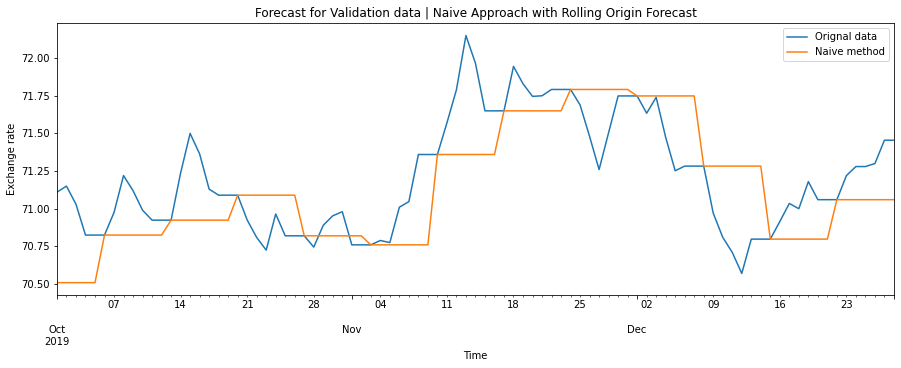

------------------------------------------------

Simple Exponential Smoothing:
Root Mean Squared Error: 0.3118
Mean Absolute Percent Error: 0.33999999999999997%



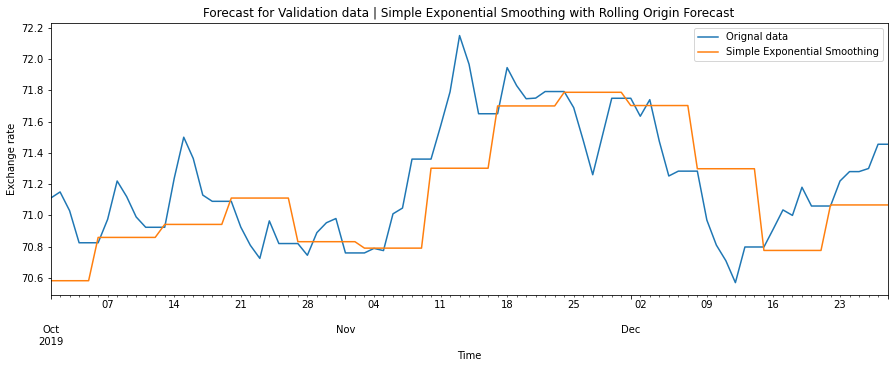

------------------------------------------------

SARIMA:
Root Mean Squared Error: 0.3045
Mean Absolute Percent Error: 0.33%



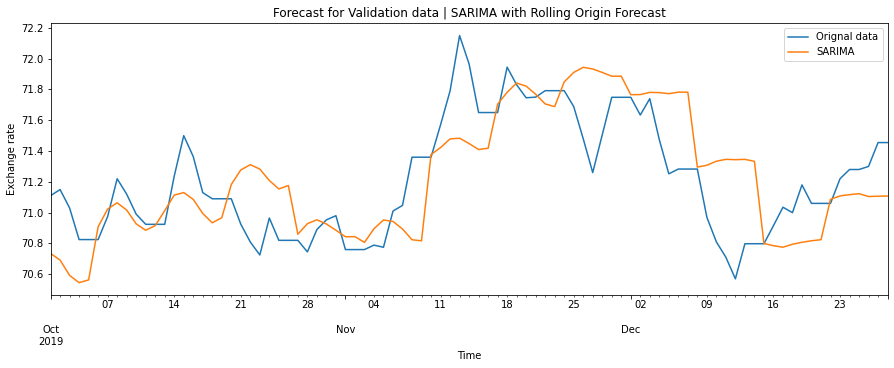

In [9]:
# forecasting using rollign origin
warnings.filterwarnings("ignore")
forecast(rolling_split_train, rolling_split_val,valid,'10-01-2019','28-12-2019',"Forecast for Validation data","Rolling Origin Forecast", True, True, False, False, True)

#### Sliding window forecast on Validation data


------------------------------------------------

Naive method:
Root Mean Squared Error: 0.3168
Mean Absolute Percent Error: 0.35000000000000003%



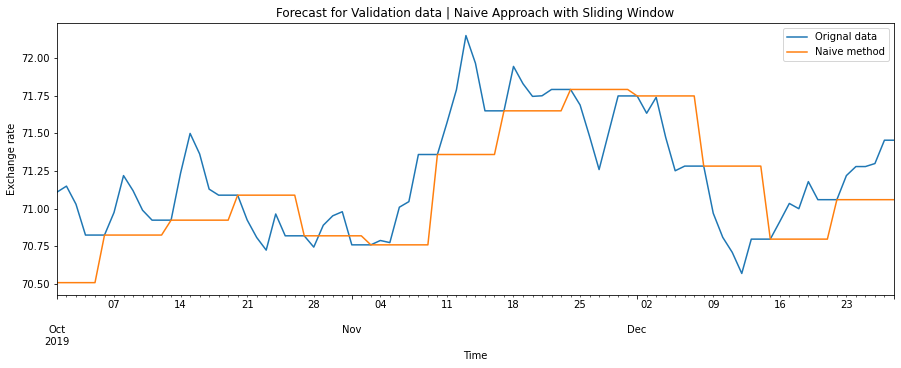

------------------------------------------------

Simple Exponential Smoothing:
Root Mean Squared Error: 0.3118
Mean Absolute Percent Error: 0.33999999999999997%



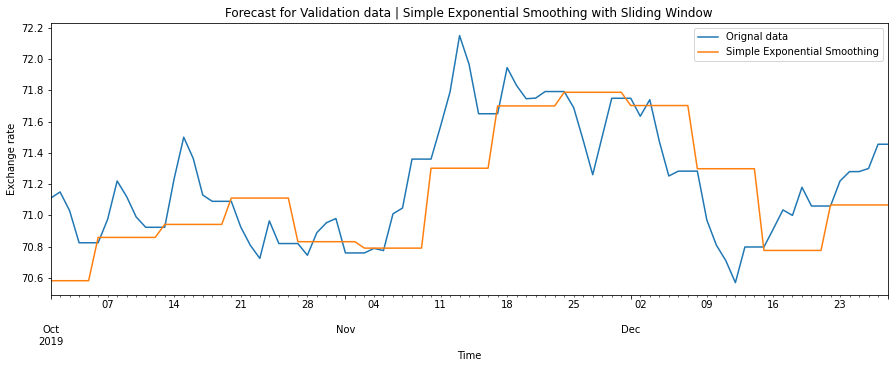

------------------------------------------------

SARIMA:
Root Mean Squared Error: 0.3937
Mean Absolute Percent Error: 0.44999999999999996%



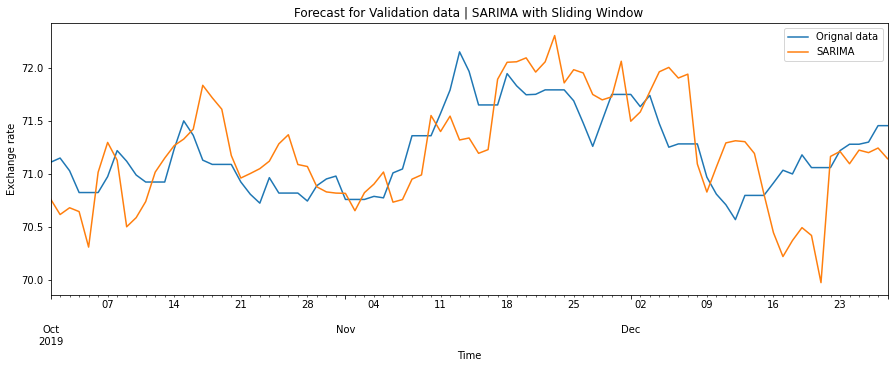

In [10]:
# forecasting using sliding window
forecast(sliding_split_train, sliding_split_val,valid,'10-01-2019','28-12-2019',"Forecast for Validation data","Sliding Window", True, True, False, False, True)

### Forecast on test data

#### Yearly Forecast using Rolling Oringin Forecast 


------------------------------------------------

Naive method:
Root Mean Squared Error: 0.5201
Mean Absolute Percent Error: 0.53%



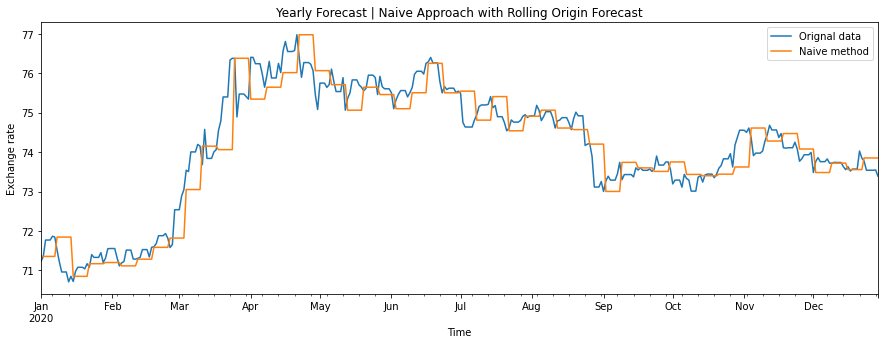

------------------------------------------------

Simple Exponential Smoothing:
Root Mean Squared Error: 0.5004
Mean Absolute Percent Error: 0.49%



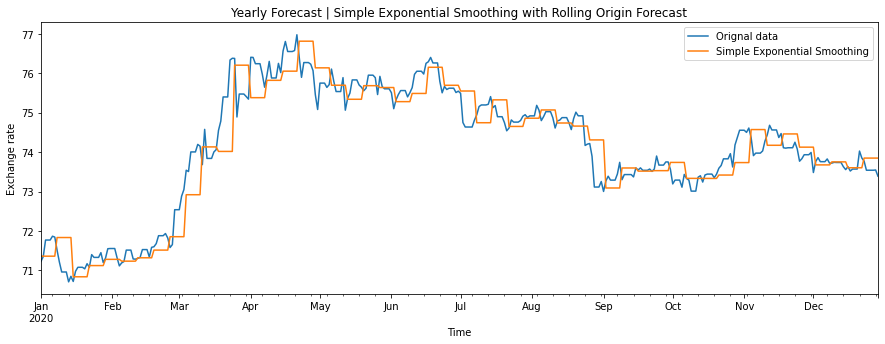

------------------------------------------------

SARIMA:
Root Mean Squared Error: 0.5147
Mean Absolute Percent Error: 0.52%



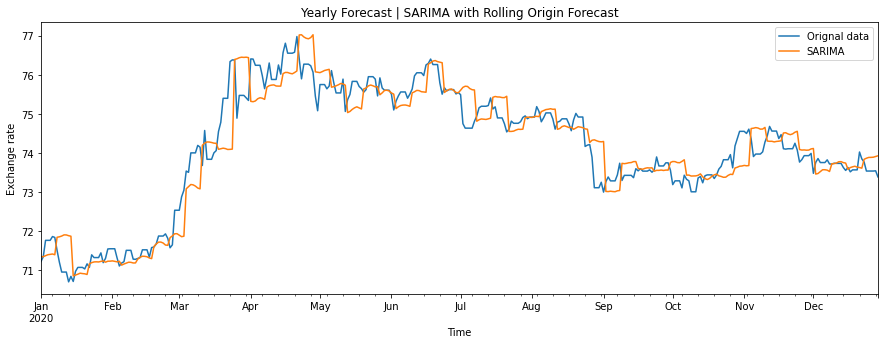

In [11]:
forecast(rolling_split_train_all, rolling_split_val_all,test_year,'01-01-2020','29-12-2020',"Yearly Forecast","Rolling Origin Forecast", True, True, False, False, True)

#### Monthly Forecast using Rolling Oringin Forecast 


------------------------------------------------

Naive method:
Root Mean Squared Error: 0.4683
Mean Absolute Percent Error: 0.52%



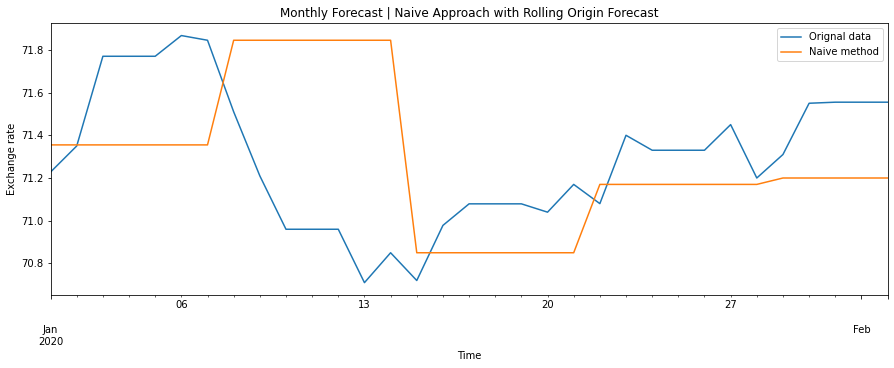

------------------------------------------------

Simple Exponential Smoothing:
Root Mean Squared Error: 0.4607
Mean Absolute Percent Error: 0.51%



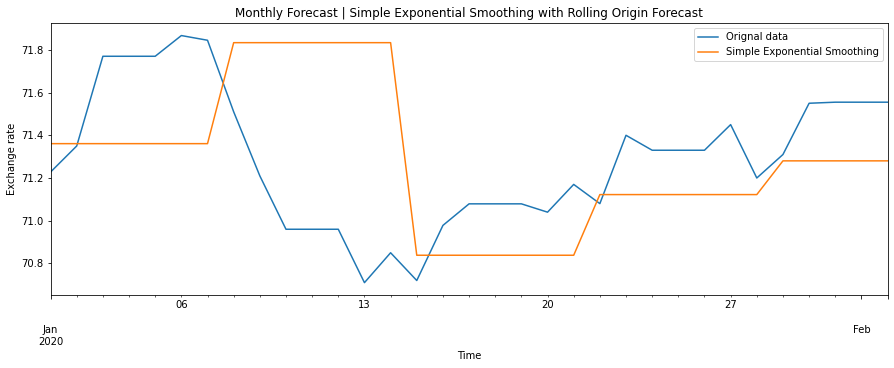

------------------------------------------------

SARIMA:
Root Mean Squared Error: 0.4667
Mean Absolute Percent Error: 0.49%



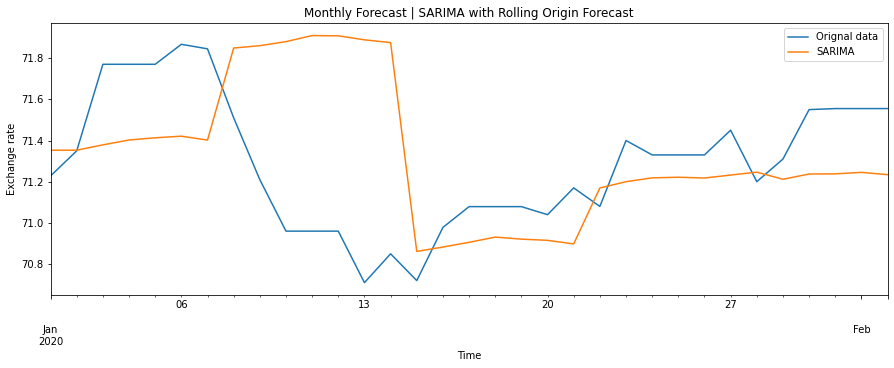

In [12]:
forecast(rolling_split_train_all, rolling_split_val_all,test_year,'01-01-2020','02-02-2020',"Monthly Forecast","Rolling Origin Forecast", True, True, False, False, True)

#### Yearly Forecast using Sliding Window


------------------------------------------------

Naive method:
Root Mean Squared Error: 0.5201
Mean Absolute Percent Error: 0.53%



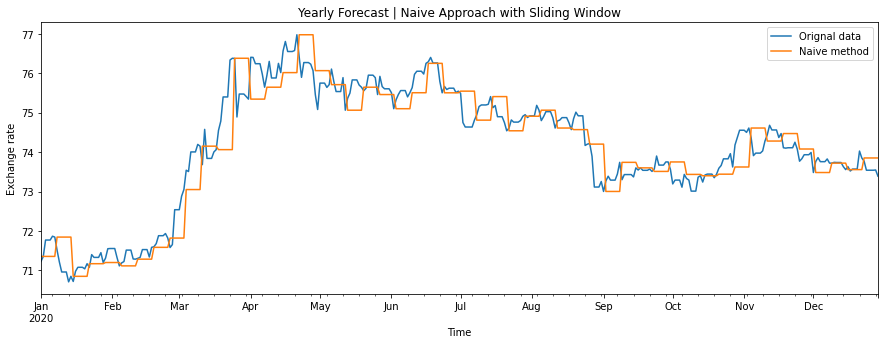

------------------------------------------------

Simple Exponential Smoothing:
Root Mean Squared Error: 0.5004
Mean Absolute Percent Error: 0.49%



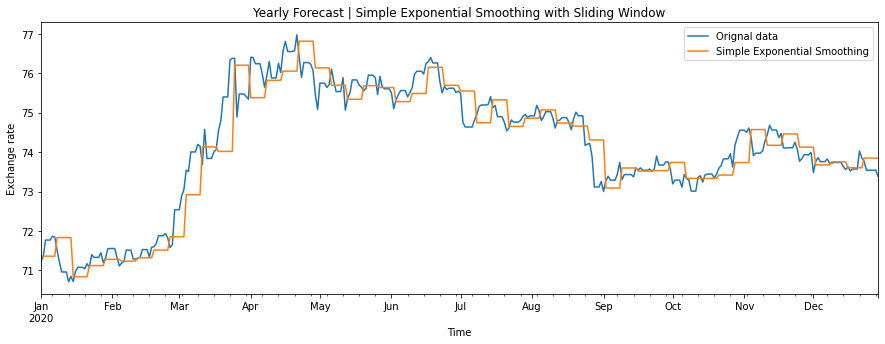

------------------------------------------------

SARIMA:
Root Mean Squared Error: 0.5924
Mean Absolute Percent Error: 0.62%



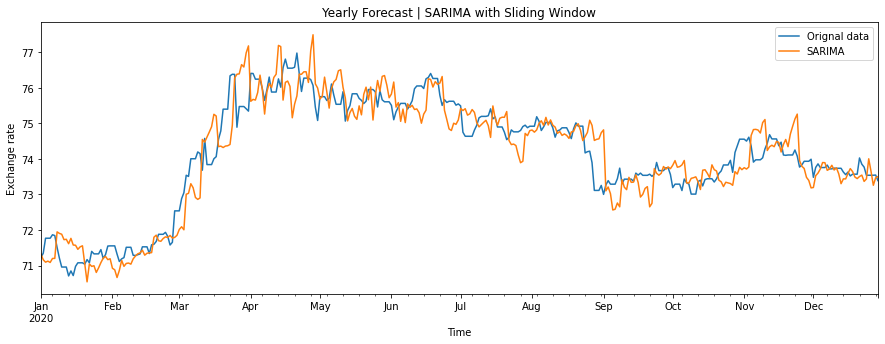

In [13]:
forecast(sliding_split_train_all, sliding_split_val_all,test_year,'01-01-2020','29-12-2020',"Yearly Forecast","Sliding Window", True, True, False, False, True)

#### Monthly Forecast using Sliding Window


------------------------------------------------

Naive method:
Root Mean Squared Error: 0.4683
Mean Absolute Percent Error: 0.52%



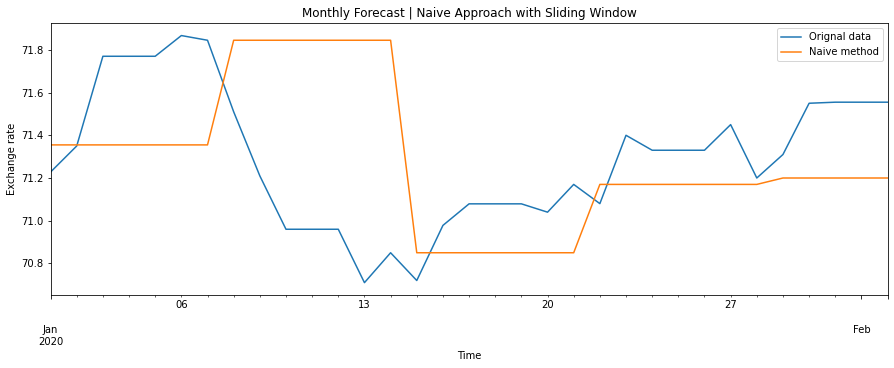

------------------------------------------------

Simple Exponential Smoothing:
Root Mean Squared Error: 0.4607
Mean Absolute Percent Error: 0.51%



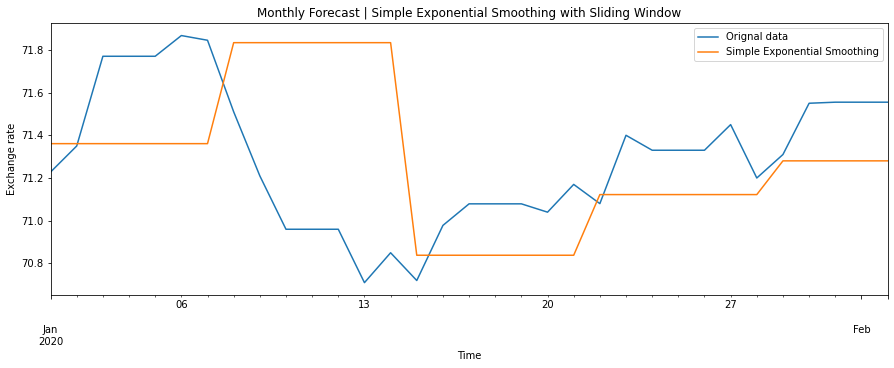

------------------------------------------------

SARIMA:
Root Mean Squared Error: 0.5682
Mean Absolute Percent Error: 0.7100000000000001%



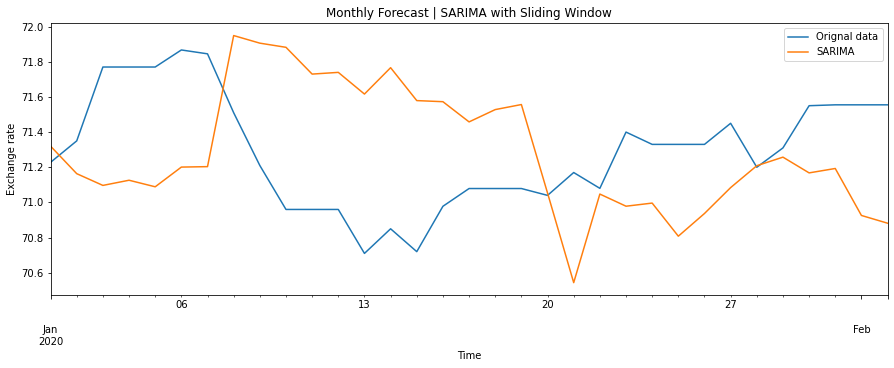

In [14]:
forecast(sliding_split_train_all, sliding_split_val_all,test_year,'01-01-2020','02-02-2020',"Monthly Forecast","Sliding Window", True, True, False, False, True)